# Data Science Analysis of Counter Strike:     Global Offensive

## Group M

>Michael Bejma |   **45180997**   
>Satwik Chodisetti | **45218641**   
>Matthew Fleming |   **45169071**   

*Data obtained via Kaggle at: https://bit.ly/2FehnuN*

## Introduction 
CS:GO is a skill-based, team-oriented, attack/defence first person shooter.
Teams of 5 compete against each other on both Terrorist and Counter-Terrorist    sides. The first team to reach 16 round wins out of 30 rounds is the winner, else the game results in a draw. 

CS:GO is renown as a skill-based shooter. Unique aspects, such as in-game economy, team strategy, individual player skill. It is a well-celebrated esport, with events such as the ESL One tournament, with a prize pool totalling over $300,000 USD.

## Problem Statement and Goals

**“What factors contribute to winning rounds and games in CS:GO?”**

This is the question we sought to answer. To understand the game and reach a conclusion, these were our goals: 
- To create heat maps of action so we can identify where duels are most likely to take place.
- Predictions based on rank, economy and use of certain weapons.
- Performing analysis on player rank vs game factors.
- Creating a model which could predict who would win a round given a number of factors.

## Our Data

Our Data was obtained via Kaggle. The data includes roughly 410,000 rounds of gameplay from the game’s September 2018 update. The data was 3.37GB. It was necessary to cull a portion the data in order to fit it into our github repository, which is limited to 1GB in size.

The dataset includes information on the game state; the state of the economy, whether bombs have been planted, what round and what map is being played. Other information regarding player positioning, weapons and damage numbers is also relevant to the analysis.

The decriptions of the data can be found in the GitHub repository, named as data_column_descriptions.pdf.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pylab as plt
from matplotlib.pyplot import imread
%matplotlib inline

#---Linear Regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

#---naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#---KMeans Clustering 
from sklearn.cluster import KMeans

#---feature selection
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

#---data processing
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

#---to clean up the presentation, given the same errors persist due to the dataset
import warnings
warnings.filterwarnings("ignore")

*The code below helps with viewing some of the outputs. This increases the limit as to how much a cell can show.*

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Importing And Preprocessing The Data
**3 main datasets were used in this analysis:** 

**mm_master_demos.csv, mm_grenades_demos.csv and map_data.csv.**

8 of the 11 .csv files from the downloaded set obtained via Kaggle were dropped. This was because the dropped files were missing key data points, making them more difficult to build an analysis around. The amount of entries in the 3 chosen .csv file were more than sufficient to help achieve the goals of our analysis.

In terms of changing the data to enable easier analysis, the names of teams were changed to be more appropriate for the analysis (note: these were permanent changes to the dataset, however we will leave them in the analysis despite their redundancy in order to demonstrate how this was achieved). Unpopular maps were dropped from the datasets because the data on these specific maps were not sufficient. This led us to focusing on the game's most popular maps.

A further large aspect of the analysis were the coordinates of the players. The values in the coordinates had to be adjusted and replaced in order to be graphed onto the images of the maps. This was achieved through the use the boundaries of the maps in order to format the values correctly. This was essential for an accurate analysis. 

In [3]:
#---importing relevant datasets
df = pd.read_csv('data/mm_master_demos.csv',index_col = 0)
df_g = pd.read_csv('data/mm_grenades_demos.csv',index_col = 0)
map_boundaries= pd.read_csv('data/map_data.csv',index_col = 0)

The code below drops the uncommon maps from the imported datasets.

In [4]:
#---dropping uncommon maps from datasets
main_maps = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']

#---from df
df = df[df['map'].isin(main_maps)]
df = df.reset_index(drop=True)

#---from df_g
df_g = df_g[df_g['map'].isin(main_maps)]
df_g = df_g.reset_index(drop=True)

*Note: The code below is redundant, however it has been included to demonstrate how the permanent alterations upon the dataset were completed.*

In [5]:
new_att_col = []
new_att_col = df['att_team']

for i in range(0, len(df)):
    if( df['att_team'][i] == 'Animal Style' ):
        new_att_col[i] = ("Team 1")
    elif(df['att_team'][i] == 'Hentai Hooligans'):
        new_att_col[i] = ("Team 2")

new_vic_col = []
new_vic_col = df['vic_team']

for i in range(0, len(df)):
    if( df['vic_team'][i] == 'Animal Style' ):
        new_vic_col[i] = ("Team 1")
    elif(df['vic_team'][i] == 'Hentai Hooligans'):
        new_vic_col[i] = ("Team 2")
df['att_team'] = new_att_col 
df['vic_team'] = new_vic_col 

The code below adjusts the coordinates of the maps so the proper values are assigned.

In [6]:
#---creating temporary dataframe
temp_df = map_boundaries.loc[df['map']]
temp_df[['att_pos_x',
         'att_pos_y',
         'vic_pos_x',
         'vic_pos_y']] = (df.set_index('map')[['att_pos_x',
                                               'att_pos_y',
                                               'vic_pos_x',
                                               'vic_pos_y']])

#---adjusting the values for plotting onto maps
temp_df['att_pos_x'] = (temp_df['ResX']*(temp_df['att_pos_x']-temp_df['StartX']))/(temp_df['EndX']-temp_df['StartX']) 
temp_df['att_pos_y'] = (temp_df['ResY']*(temp_df['att_pos_y']-temp_df['StartY']))/(temp_df['EndY']-temp_df['StartY'])   
temp_df['vic_pos_x'] = (temp_df['ResX']*(temp_df['vic_pos_x']-temp_df['StartX']))/(temp_df['EndX']-temp_df['StartX'])
temp_df['vic_pos_y'] = (temp_df['ResY']*(temp_df['vic_pos_y']-temp_df['StartY']))/(temp_df['EndY']-temp_df['StartY'])

df[['att_pos_x',
    'att_pos_y',
    'vic_pos_x',
    'vic_pos_y']] = temp_df[['att_pos_x',
                             'att_pos_y',
                             'vic_pos_x',
                             'vic_pos_y']].values

# Contact Point Analysis


We used K-means clustering to find the zones in which combat happens on a map.
The data was separated by map and side. The idea of this analysis is to understand where most engagements happen, in order to optimise around this. For example, utilising grenade throws. de_dust2 is the most recognisable map in CS:GO. We were able to identify the relevant locations with  this map.

## Creating a Smaller Dataset to Analyse

In order to conduct our analysis and not overcrowd the maps with data, a more workable and smaller dataset must be created from the dataframe *df*. In order to choose the rounds, a new dataframe containing only pistol rounds (the first round of every half) is created. This will be the basis of all of the contact point analyses.

In [7]:
#---creating a dataframe of only pistol rounds
all_pistols = ['USP', 'Glock', 'P2000', 'P250', 'Tec9', 'FiveSeven', 'Deagle', 'DualBarettas', 'CZ']
df_p = df[(df['round'].isin([1,16])) & (df['wp'].isin(all_pistols))]
print("Total Number of Pistol Rounds: %i" % df_p.groupby(['file', 'round'])['tick'].first().count())

Total Number of Pistol Rounds: 857


## K-Means Cluster Analysis

The K-Means Clustering algorithm uses data points to find cluster centres, and then groups the data points into clusters. For this analysis, the location of players is being used in order to identify zones of maps that see the most action. Clustering will divide the map into identifiable sections.

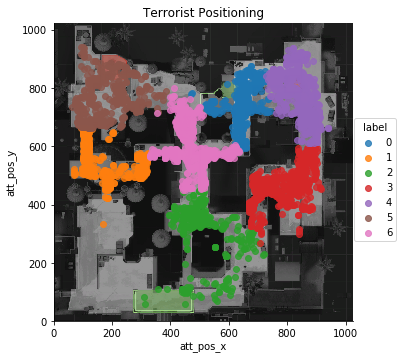

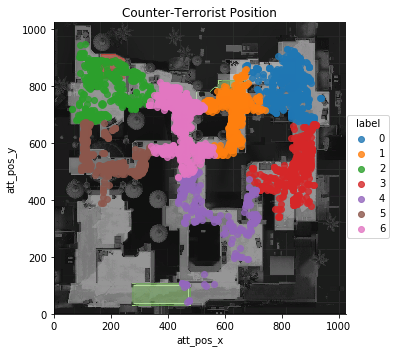

In [8]:
#---function to print clustering of high traffic areas for both T and CT sides
def k_means_clustering_by_location(sample_map):
    curr_map = imread('data/maps/'+sample_map+'.png')   
    terr_df =  df_p.loc[(df_p.map == sample_map) & (df_p.att_side == 'Terrorist')]
    cont_df = df_p.loc[(df_p.map ==  sample_map) & (df_p.att_side == 'CounterTerrorist')]
    
    terr_plot_kmt = terr_df[['att_pos_x', 'att_pos_y']].copy()
    kmeans = KMeans(n_clusters=7)
    kmeans.fit(terr_plot_kmt)
    terr_plot_kmt['label'] = kmeans.predict(terr_plot_kmt)
    sns.lmplot('att_pos_x', 'att_pos_y', data=terr_plot_kmt, fit_reg=False, hue='label')
    plt.imshow(curr_map, zorder=0,extent=[0.0, 1024, 0., 1024])
    plt.title('Terrorist Positioning')
   
    cont_plot_kmt = cont_df[['att_pos_x', 'att_pos_y']].copy()
    kmeans = KMeans(n_clusters=7)
    kmeans.fit(cont_plot_kmt)
    cont_plot_kmt['label'] = kmeans.predict(cont_plot_kmt)
    sns.lmplot('att_pos_x', 'att_pos_y', data=cont_plot_kmt, fit_reg=False, hue='label')
    plt.imshow(curr_map, zorder=0,extent=[0.0, 1024, 0., 1024])
    plt.title('Counter-Terrorist Position')    

#---any map can be called with this function, but dust2 will be used as an example
k_means_clustering_by_location('de_dust2')

The output above shows where Terrorists and Counter-Terrorists most commonly fight in. The k-means algorithm divides the map into sections. For example, the top left and top right clusters on both plots can be easily identified as 'Bombsite B' and 'Bombsite A' respectively. Each of the clusters pertains to one or two specific areas of the map.

Even the absence of data (the areas towards the bottom left of the plot) gives us information about that space on the map. Nothing seems to happen in those locations. This analysis could be repeated on any of the maps, and these zones of heavy traffic can be clearly identified.

An issue with this way of plotting is that it shows us *where* things happen, but not the *density*. 

## Heat Maps

Heat maps address the issue of *density* raised by the k-means clustering analysis. Heat maps of the action will show us where the most amount of fights happen. We will conduct a heat map analysis across all maps, and this will show us where a majority off all the action is taking place.

The function below creates heat maps for both Terrorists and Counter-Terrorists on a given map input.

In [9]:
def heat_map_by_Location(map_name):
    #---sample map can be changed to take all inputs
    sample_map = map_name
    curr_map = imread('data/maps/'+sample_map+'.png') 
    fig,(ax1, ax2) = plt.subplots(1,2,figsize=(18,16))

    #---aligns the image to the graph and limits the boundraies of the ploting to between 0 and 1024(sie of the map)
    ax1.imshow(curr_map, zorder=0, extent=[0.0, 1024, 0., 1024])
    ax2.imshow(curr_map, zorder=0, extent=[0.0, 1024, 0., 1024])
    plt.xlim(0,1024)
    plt.ylim(0,1024)

    #---plotting the Terrorist side
    plot_cleanData = df_p[(df_p.map == sample_map) & (df_p.att_side == 'Terrorist')]
    
    #---plots the x and the y position of the Terroists 
    sns.kdeplot(plot_cleanData['att_pos_x'], plot_cleanData['att_pos_y'], cmap='Reds', bw=15, ax=ax1)
    ax1.set_title('Terrorist Positioning')

    #---plotting the Counter - Terrorist side
    plot_cleanData = df_p[(df_p.map == sample_map) & (df_p.att_side == 'CounterTerrorist')]
    
    #---plots the x and the y position of the Counter Terroists 
    sns.kdeplot(plot_cleanData['att_pos_x'], plot_cleanData['att_pos_y'], cmap='Blues', bw=15, ax=ax2)
    ax2.set_title('Counter-Terrorist Positioning')

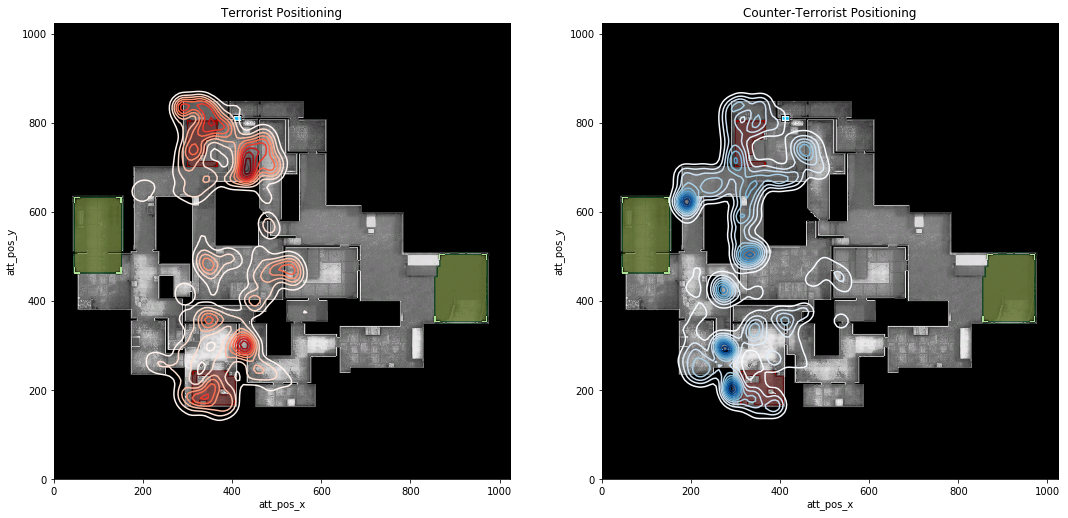

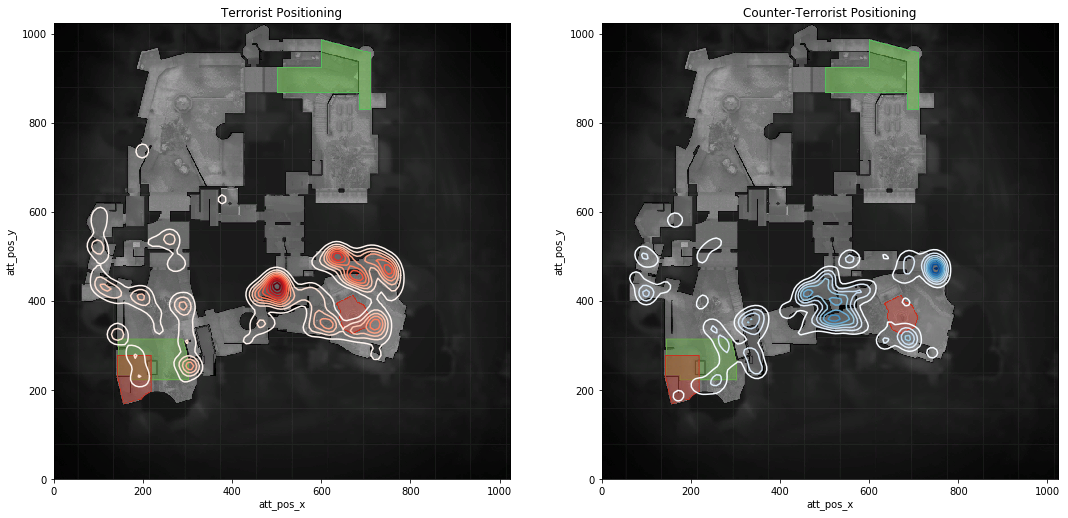

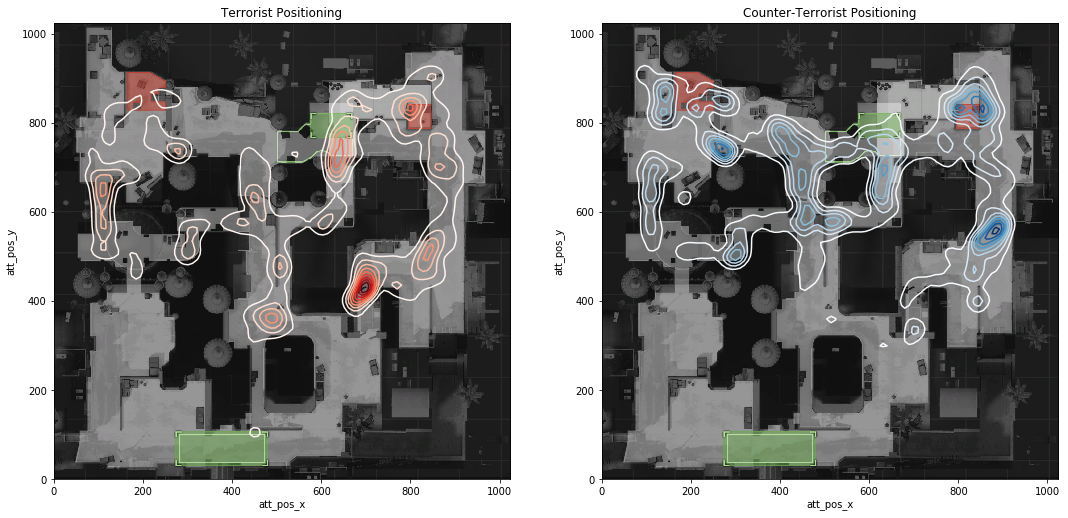

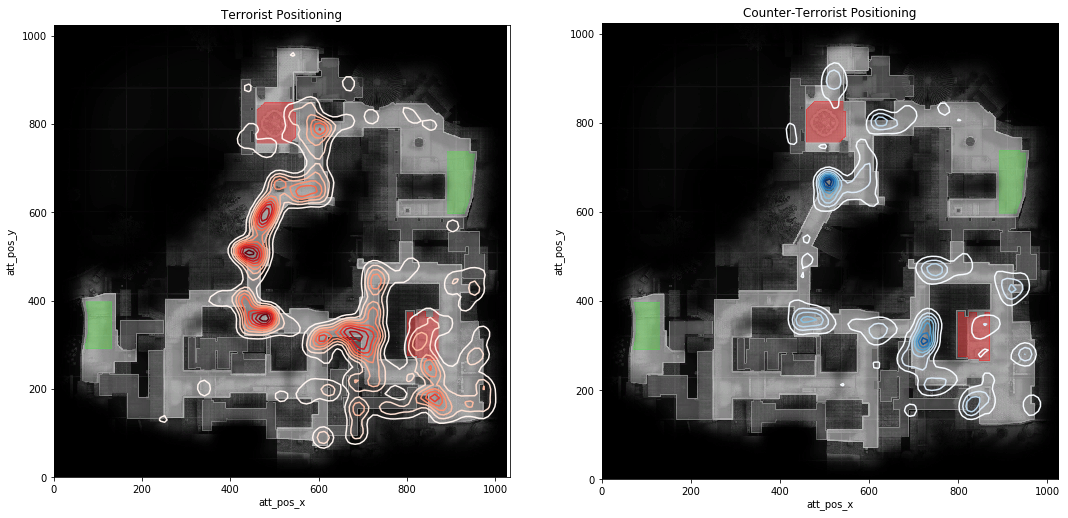

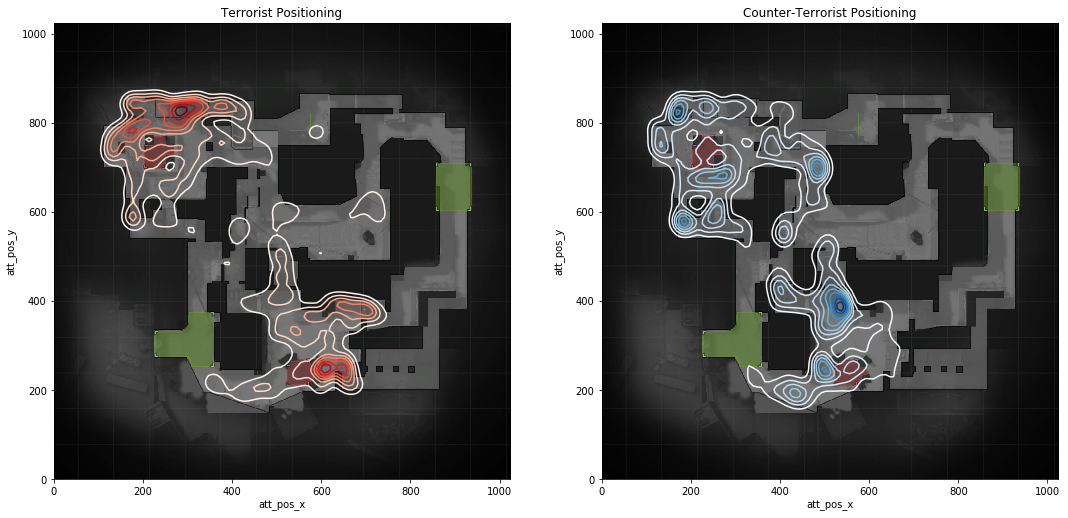

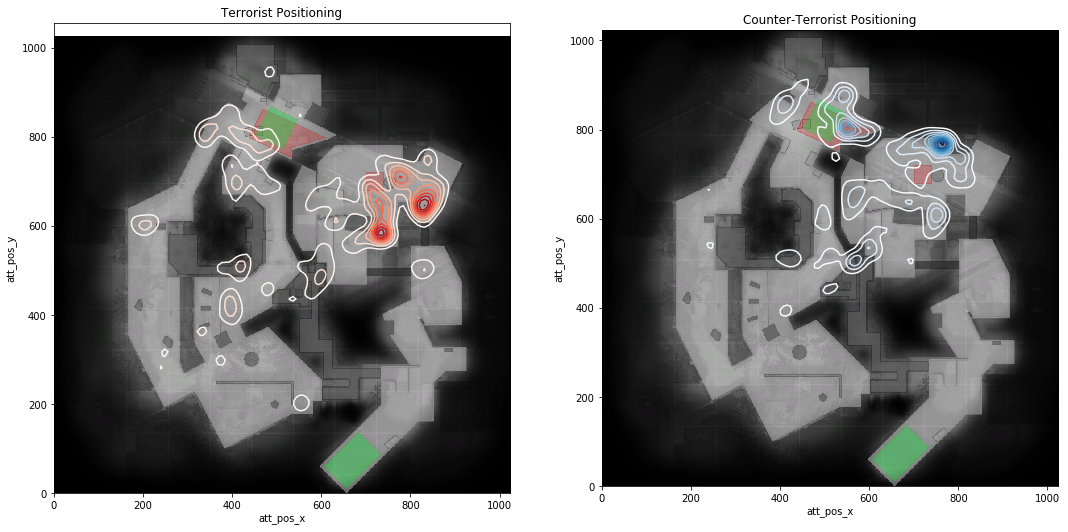

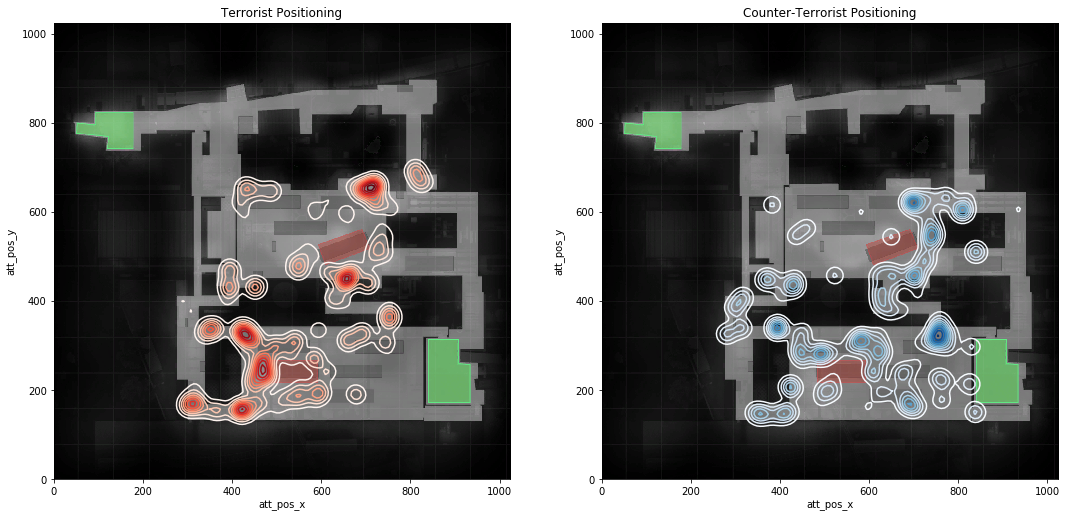

In [10]:
#---printing the heat maps for all maps in the dataset
for i in range(0, len(main_maps)):
    heat_map_by_Location(main_maps[i])

The plots above tell us a much more visual story aboout the zones of action happening in certain maps. Used in conjuction with the k-means plots, it can be extrapolated what the most important areas of each of the maps are. These plots can be used to identify the best locations for use of tactical tools such as Flashbang and HE grenades.

This can be performed across every map, and the results can be used to determine how maps are differently played. The analyses reveal aspects about the map design. For example: de_dust2 plays differently from de_cbble, because it can be shown that on de_dust2 most of the action happens on approach to the bombsites, whereas in de_cbble, it happens while on the bombsites.

# Weapon and Rank Analysis

In this section, we take a closer look at the use of weapons across the different ranks, in order to understand how different skill levels utilise the tools available to them in CS:GO. The weapons used in CS:GO seem as if they would be of great importance, but this analysis should allow for an understanding of how they are used by different players.

In [11]:
#---creating a new dataframe with the relevant datasets
df_hits = df[['wp','wp_type','hitbox','hp_dmg','att_rank']]

#---dropping null values and resetting the index
df_hits = df_hits.dropna()
df_hits = df_hits.reset_index(drop=True)

## Weapon Hits

Below are some graphs that examine the quantity of hits made with certain weapons.

Text(0,0.5,'Number of hits')

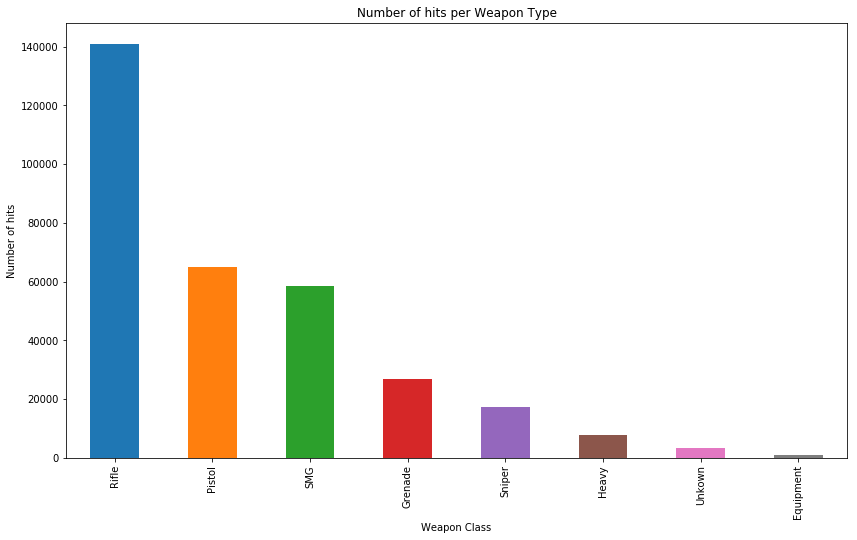

In [12]:
plot = df_hits['wp_type'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits per Weapon Type",)
plot.set_xlabel("Weapon Class")
plot.set_ylabel("Number of hits")

The graph above shows that rifles are the most common weapons, with pistols and SMGs behind them. It should be noted that sniper rifles are more powerful weapons, meaning they require less hits to be effective. Consequently, they do not appear to be as prolific as rifles, pistols and SMGs in this graph. 

To understand how these groups break down, below is a graph that breaks this chart down further into individual weapons.

Text(0,0.5,'Number of hits')

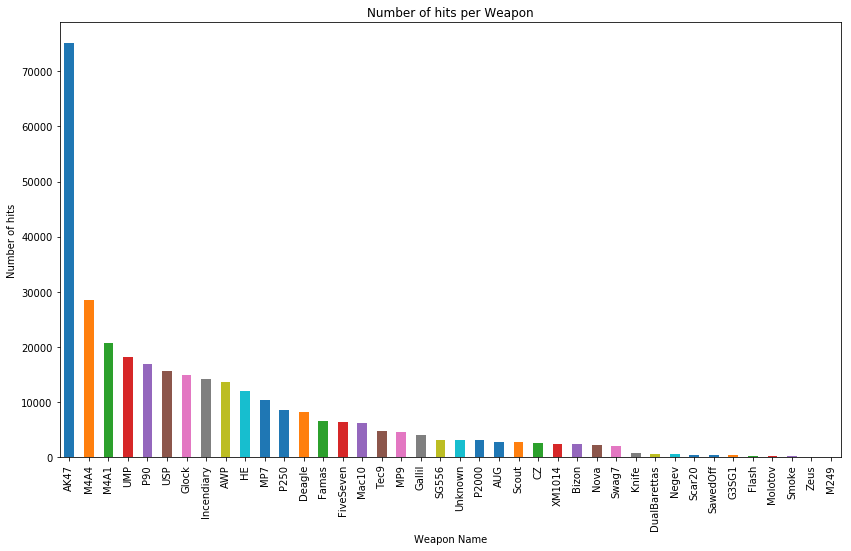

In [13]:
plot = df_hits['wp'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits per Weapon",)
plot.set_xlabel("Weapon Name")
plot.set_ylabel("Number of hits")

This graph shows that the AK-47 is the most popular weapon in CS:GO. This is despite it having a one-hit-kill capability and only being available for purchase by one side; the Terrorists. Even considering that the Counter-Terrorists have more options to choose from (the most popular rifles being the M4A4 and the M4A1), their numbers still pail in comparison to the status of the AK-47. This means that quite often, Counter-Terrorists pick up AK-47s dropped by Terrorists.

The analysis continues below with locations of hits.

Text(0,0.5,'Number of hits')

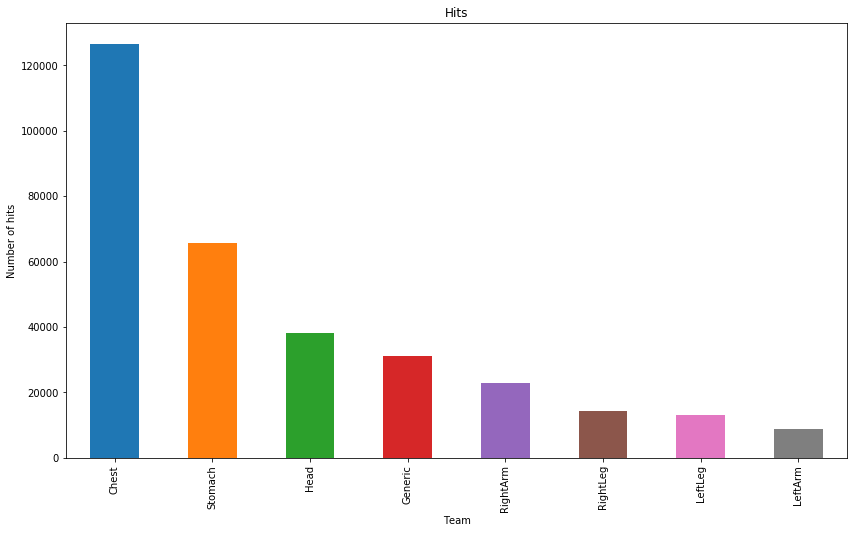

In [14]:
plot = df_hits['hitbox'].value_counts().plot(kind='bar',figsize=(14,8), title="Hits",)
plot.set_xlabel("Team")
plot.set_ylabel("Number of hits")

As shown by the chart, most hits landed on players are centremass -- the largest part of the body, consisting of the chest and stomach. This is followed by the head, which is a vital zone, dealing 4x base damage of a weapon if this is the location hit. Understandably, the ability to consistenyly hit this vital zone is an invaluable skill for the game.

The purpose of these graphs was to understand the data for the following linear regression. The goal is to identify whether or not there is a correlation between type of weapon and location of hits; whether certain weapons give advantages.

## Linear Regression on Weapons

### Data Preparation

In [15]:
#---assigning category codes to data in order to analyse it
df_hits["hitbox"] = df_hits["hitbox"].astype('category')
df_hits["hitbox_cat"] = df_hits["hitbox"].cat.codes 

df_hits["wp_type"] = df_hits["wp_type"].astype('category')
df_hits["wp_type_cat"] = df_hits["wp_type"].cat.codes 

df_hits["wp"] = df_hits["wp"].astype('category')
df_hits["wp_cat"] = df_hits["wp"].cat.codes 
df_hits = df_hits.dropna()

#---creating bins of health damage for which to examine damage numbers
hp_to_bins = []
for i in range(0,len(df_hits)):
    if (df_hits["hp_dmg"][i] <=25):
        hp_to_bins.append(0)
    elif (df_hits["hp_dmg"][i] <= 50):
        hp_to_bins.append(1)
    elif (df_hits["hp_dmg"][i] <= 75):
        hp_to_bins.append(2)
    else :
        hp_to_bins.append(3)

df_hits["hp_to_bins"] = hp_to_bins

### Performing The Analysis

In [16]:
#---code to perform linear regression
reg = linear_model.LinearRegression()
data = df_hits[['hitbox_cat']]
target = df_hits[['hp_to_bins']]
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size = 0.70, random_state=0)

reg.fit(X_train,y_train)

print ("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[0.0056581]] + [0.58296906]


In [17]:
#---code to produce prediction values
predicted = reg.predict(X_test)
mse = ((np.array(y_test)-predicted)**2).sum()/len(y_test)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("R-Squared:", r2)

MSE: 0.7674967663926506
R-Squared: 0.0003764615956923789


Shown by the predictive R-Squared, there is no correlation between the location of the hit and the damage done. The regression is unsuccessful, so the analysis will continue with a multinomial naive bayes below in order to see if damage can be predicted by weapon type and hitbox.

In [18]:
#---performing a multinomial naive bayes analysis on the data
clf = MultinomialNB()
data = df_hits[['wp_cat','hitbox_cat']]
target = df_hits[['hp_to_bins']]
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size = 0.70, random_state=0)

y_train=y_train.as_matrix()
clf.fit (X_train, y_train)

y_test=y_test.as_matrix()
y_pred = clf.predict(X_test)

print("Multinomial:", np.mean(y_pred==y_test))

Multinomial: 0.5036205821425516


The results from the naive bayes analysis -- similar to the linear regression -- are poor in the context of the data, though there is some level of prediction to be made. What this means is that the damage numbers can be variable, and there is no concrete number that a weapon will do in damage. Things that change weapon damage can include range, hit location, and whether or not the target is wearing armour. This tells us that there are many nuances to how CS:GO calculates its damage.

## Weapons and Player Ranking

CS:GO has an in-built player ranking system, determined by a player's performance in games prior. There are 18 different ranks available, with the higher the rank, the higher the skill. To analyse the disparity between high and low ranks, the data is split below. For the purpose of this analysis, high rank is defined as 16 and above, and low rank as 8 and below.

In [19]:
#---creating two separate dataframes based on skill levels
df_hits_highrank = df_hits[df_hits.att_rank >=16]
df_hits_lowrank = df_hits[df_hits.att_rank<=8]

### High Level Weapon Use

Text(0,0.5,'Number of hits')

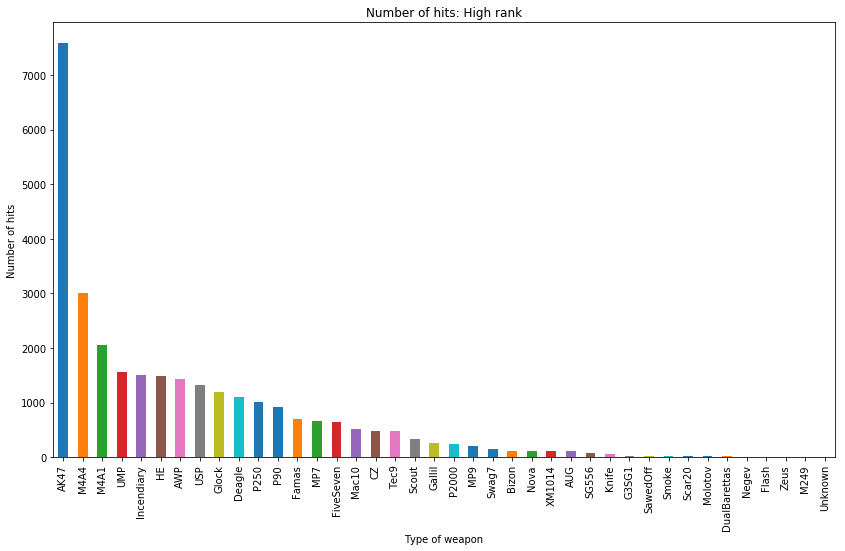

In [20]:
plot = df_hits_highrank['wp'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits: High rank",)
plot.set_xlabel("Type of weapon")
plot.set_ylabel("Number of hits")

Similarly to the overall weapon hits graphs above, it is clear that the AK-47 is the dominant weapon. It used almost 3 times as often as the next most used weapon, the M4A4. This is interesting for the same reasons as earlier -- the AK-47 is only available to the Terrorist side, but this data implies that the AK-47 is being picked up by Counter-Terrorists from fallen Terrorists. The variety of weapons is not as wide as the earlier graphs might have suggested.

Grenades such as Incendiary and HE grenades are used fairly often in high-ranked play. Higher level players would use these grenades for zoning purposes (to force the enemy players in and out of certain positions).

### Low Level Weapon Use

Text(0,0.5,'Number of hits')

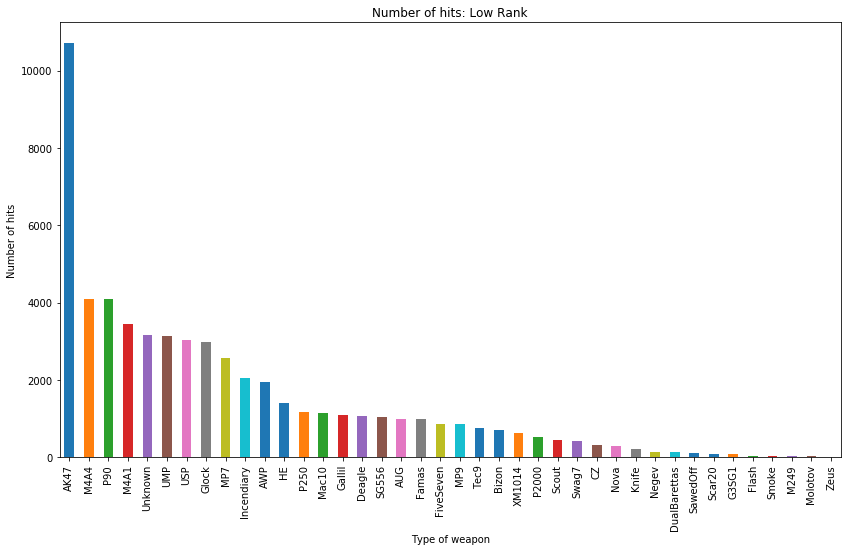

In [21]:
plot = df_hits_lowrank['wp'].value_counts().plot(kind='bar',figsize=(14,8), title="Number of hits: Low Rank",)
plot.set_xlabel("Type of weapon")
plot.set_ylabel("Number of hits")

This low-level weapon use graph looks similar to the high-level weapon-use graph, but there are some important differences. Similar to the graphs prior, the AK-47 is a dominant. But following the AK-47 and the M4A4, the M4A1 has lost its #3 spot to the P90. The P90 is a gun renowned for its low cost and forgiving nature. This would explain its more frequent use by lower ranks.

Furthermore, compared to the higher ranked players, lower-ranked players use considerably fewer grenades, meaning that their understanding of the game and how to best utilise the strategy of zoning is not fully-developed, like the higher level players. 

There is a more sizeable distribution of weapon use from the lower-ranked players, meaning that they do not have the same grasp as to 'what is best', or they simply do not take the game as seriously. 

Lastly, a category called 'Unknown' has appeared. According to the dataset, this refers to environmental damage, such as falling. Its absence in the high-ranked players suggest that lower-ranked players are more accident-prone, unlike high-ranked players who do not seem to take damage from the environment at all.

## Plotting Smoke Spots

Smoke grenades are a vital tactical tool in CS:GO. These grenades obscure vision, blocking lines of sight in order to conceal actions behind them. They can be thrown from immense distances into precise places, known as 'smoke spots'. To conduct this analysis, data was drawn from the dataset *mm_grenade_demos*.

The only parts of this dataframe that are important to us are where the grenade was thrown from, where it landed, and the rank of the person who threw it. Similar to the weapons analysis, the players will be divided into two separate groups of high and low rank.

In [22]:
#For the purpose of this I will be looking at only smoke grenades and only at a specific map to make it easier
index = [(df_g['nade']=='Smoke') & (df_g['map']=='de_dust2')][0]
df_g_smokes = df_g[index]
df_g_smokes = df_g_smokes[['nade_land_x','nade_land_y','att_rank','att_pos_x','att_pos_y']]

df_g_smokes.dropna()
df_g_smokes = df_g_smokes.reset_index()

In [23]:
#---creating two separate dataframes based on skill levels
df_g_smokes_highrank = df_g_smokes[df_g_smokes.att_rank >=16]
df_g_smokes_lowrank = df_g_smokes[df_g_smokes.att_rank<=8]

In [24]:
#---these definitions convert the maps' coordinates properly to the map image when graphed
#---code obtained at: https://bit.ly/2JT6Vrs
def pointx_to_resolutionx(xinput, startX=-2486, endX=2127, resX=1024):
    sizeX=endX-startX
    if startX < 0:
        xinput += startX *(-1.0)
    else:
        xinput += startX
    xoutput = float((xinput / abs(sizeX)) * resX);
    return xoutput

def pointy_to_resolutiony(yinput,startY=-1150,endY=3455,resY=1024):
    sizeY=endY-startY
    if startY < 0:
        yinput += startY *(-1.0)
    else:
        yinput += startY
    youtput = float((yinput / abs(sizeY)) * resY);
    return resY-youtput

### High Rank Smoke Throws (de_dust2)

In [25]:
#---applying the correct coordinates to the dataframe so the plot points will fit over a man
df_g_smokes_highrank['thrower_xpos'] = df_g_smokes_highrank['att_pos_x'].apply(pointx_to_resolutionx)
df_g_smokes_highrank['thrower_ypos'] = df_g_smokes_highrank['att_pos_y'].apply(pointy_to_resolutiony)
df_g_smokes_highrank['nade_ypos'] = df_g_smokes_highrank['nade_land_y'].apply(pointy_to_resolutiony)
df_g_smokes_highrank['nade_xpos'] = df_g_smokes_highrank['nade_land_x'].apply(pointx_to_resolutionx)

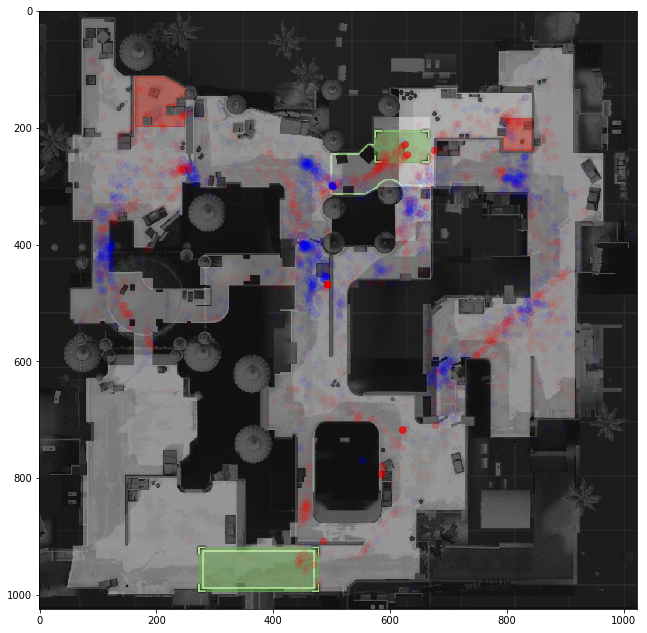

In [26]:
#---printing the plot
im = plt.imread('data/maps/de_dust2.png')
plt.figure(figsize=(11,11))
t = plt.imshow(im)
t = plt.scatter(df_g_smokes_highrank['nade_xpos'], df_g_smokes_highrank['nade_ypos'],alpha=0.05,c='blue')
t = plt.scatter(df_g_smokes_highrank['thrower_xpos'], df_g_smokes_highrank['thrower_ypos'],alpha=0.05,c='red')

The colour blue indicates where the smoke grenade landed, and the colour red indicates where the smoke grenade was thrown from.

There are less data points for higher-ranked players, but the principal of what the data implies remains unchanged. The smoke grenades are not only landing in consistent places, but are being thrown from consistent places. The concentrated red and blue dots are 'smoke spots'. These 'smoke spots' also correspond to some of the hottest areas found in the **heat map** portion of the analysis.

### Low Rank Smoke Throws (de_dust2)

In [27]:
#---applying the correct coordinates to the dataframe so the plotted points will fit over a map
df_g_smokes_lowrank['thrower_xpos'] = df_g_smokes_lowrank['att_pos_x'].apply(pointx_to_resolutionx)
df_g_smokes_lowrank['thrower_ypos'] = df_g_smokes_lowrank['att_pos_y'].apply(pointy_to_resolutiony)
df_g_smokes_lowrank['nade_ypos'] = df_g_smokes_lowrank['nade_land_y'].apply(pointy_to_resolutiony)
df_g_smokes_lowrank['nade_xpos'] = df_g_smokes_lowrank['nade_land_x'].apply(pointx_to_resolutionx)

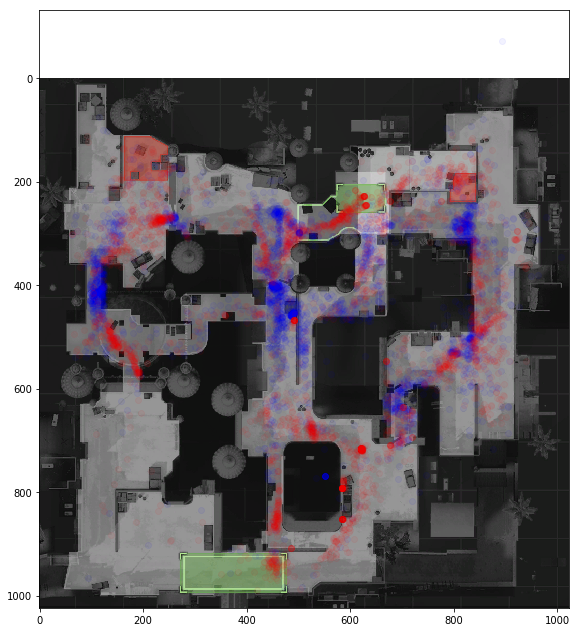

In [28]:
#---printing the plot
im = plt.imread('data/maps/de_dust2.png')
plt.figure(figsize=(11,11))
t = plt.imshow(im)
t = plt.scatter(df_g_smokes_lowrank['nade_xpos'], df_g_smokes_lowrank['nade_ypos'],alpha=0.05,c='blue')
t = plt.scatter(df_g_smokes_lowrank['thrower_xpos'], df_g_smokes_lowrank['thrower_ypos'],alpha=0.05,c='red')

The colour blue indicates where the smoke grenade landed, and the colour red indicates where the smoke grenade was thrown from.

The difference between high and low-ranked play is clear from this plot. There is an element of randomness to where smoke grenades land and where they're thrown from, indicated by the trails of red and blue present on the plot. The same 'smoke spots' still appear in the plot above, however there are also many others that miss their mark or land in a less-than-ideal location. For example, in this plot, one person threw their grenade out of bounds, which is why the map positioning is slightly off.


## Overall Rank Analysis

Both the weapons and smoke grenade analysis show that while being a higher-ranked player doesn't guarantee being a better player (the same strategies are present in both groups), but it shows that higher-ranked players are more consistent in their ability, meaning they can perform certain tasks for a larger majority of time, thus giving them a higher chance of winning.


# Predicting Outcomes of Games and Rounds

## Analysis of Round and Game-Winning Factors

What are the factors that contribute to winning rounds and games in CS:GO? How much do they affect the outcome? To determine this, we create a new dataframe. This dataframe will be used to conduct feature ranking and naive bayes analyses in order to identify what factors contribute most substantially to the outcome of games and rounds in CS:GO, and to what extent that contribution affects the outcome overall.

In [29]:
#--creating a new dataframe for analysis
df_nb = df[['file','map','round','is_bomb_planted','winner_team','winner_side',
           'round_type','ct_eq_val','t_eq_val','avg_match_rank']]

#---dropping all duplicate rounds, resulting in one entry per round of a match
df_nb = df_nb.drop_duplicates(['file','round'],keep='last')

#---encoding the labels of map, bomb planted, and round type to facilitate naive bayes analysis
le = preprocessing.LabelEncoder()

df_nb["map"] = df_nb["map"].astype('category')
df_nb["map"] = df_nb["map"].cat.codes 

df_nb["is_bomb_planted"] = df_nb["is_bomb_planted"].astype('category')
df_nb["is_bomb_planted"] = df_nb["is_bomb_planted"].cat.codes 

df_nb["round_type"] = df_nb["round_type"].astype('category')
df_nb["round_type"] = df_nb["round_type"].cat.codes 

#---fixing the index
df_nb = df_nb.reset_index(drop=True)
df_nb.dropna(how='any', inplace=True)

#---creating the target data for use in the analysis
target_team = df_nb['winner_side']
target_side = df_nb['winner_team']
df_nb = df_nb.drop(columns=['file','winner_side','winner_team'])

## Ranking Features

Below is a function used to find which features most strongly influence a piece of target data.

In [30]:
#---algorithm to find the highest ranking features
#---obtained from: https://bit.ly/2SJoYUV

def rank_features(df, target):
    #---declaring train and test variables
    X_train= df.sample(frac = 0.7, replace = False, random_state=0)
    X_test = df.drop(X_train.index)
    y_train = target.sample(frac = 0.7, replace = False, random_state=0)
    y_test = target.drop(y_train.index)
    
    forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
    forest.fit(X_train,y_train)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    
    #---print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In order to determine the strongest factors, we must run this analysis, and then drop the columns least relevant to the data.

This is what the features mean:
- Feature 0: Map
- Feature 1: Round
- Feature 2: Is Bomb Planted
- Feature 3: Round Type
- Feature 4: CT Equipment Value
- Feature 5: T Equipment Value
- Feature 6: Average Match Rank

### Team Wins (First to 16 rounds)

In [31]:
#---printing the factors that determine team wins
print("target = team")
rank_features(df_nb, target_team)
print()

target = team
Feature ranking:
1. feature 2 (0.247247)
2. feature 4 (0.221831)
3. feature 5 (0.204434)
4. feature 1 (0.125846)
5. feature 6 (0.102512)
6. feature 0 (0.067461)
7. feature 3 (0.030668)



The features that rank the highest for whether or not a team wins a game are:
- Is Bomb Planted
- CT Equipment Value
- T Equipment Value
- Round

From this we can infer a few things. The team that plants more bombs is likely to be the team that wins all 16 rounds and wins the game. Given more spending power for equipment, a team is more likely to win a round (CTs being slightly better off than Ts). This could also be because a team who is winning more rounds will have more money, but that does not significantly affect the analysis, only the conclusions we could draw. Additonally, the given round that is being played is important. This could be because which round is being played (early or late into the game) will change the power balance between the sides in terms of spending power for equipment.

### Side Wins (The Victors of a Single Round)

In [32]:
#---printing the factors that determine individual round wins
print("target = side")
rank_features(df_nb, target_side)
print()

target = side
Feature ranking:
1. feature 1 (0.306915)
2. feature 4 (0.213645)
3. feature 5 (0.208404)
4. feature 6 (0.104622)
5. feature 0 (0.079053)
6. feature 2 (0.053686)
7. feature 3 (0.033676)



The features that rank the highest for whether or not a side wins a round are:
- Round
- CT Equipment Value
- T Equipment Value
- Average Match Rank

Round is the most important factor for whether or not a team wins a round. This is more than likely because as touched on earlier, the game mechanics favour one team over the other at different stages of the entire match. It is generally known that Ts are stronger early game, and CTs are stronger late game. Similarly to the teams analysis, the equipment values for both teams do both play an important role in determining which team will win a round. The average match rank also seems to matter, though it is unclear why it is important.

### Dropping Weak Values

To improve the quality of our analysis, we will drop the values of Map, Round Type and Average Match Rank. This is because Map and Round Type were consistently at the bottom of the feature rankings, and Average Match Rank does not necessarily tell us enough information about what is happening in the game, because it is an average rank of *all* players in the match, and does not tell us anything about a disparity in skill.

In [33]:
#---dropping weak values from df_nb
df_nb = df_nb.drop(columns=['map','round_type','avg_match_rank'])

## Naive Bayes Analyses

Below, we create a naive bayes analysis function to allow us to perform the analysis in a modular manner.

In [34]:
def naive_bayes_analysis(seed, data, target):
    X_train= data.sample(frac = 0.7, replace = False, random_state=seed)
    X_test = data.drop(X_train.index)
    y_train = target.sample(frac = 0.7, replace = False, random_state=seed)
    y_test = target.drop(y_train.index)
    
    #multinomial
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
      
    #descritized
    enc = KBinsDiscretizer(n_bins=5, encode='ordinal')
    X_bin = enc.fit_transform(X_train)
    X_bin_test = enc.fit_transform(X_test)
    encmnb = MultinomialNB()
    encmnb.fit(X_bin, y_train)
    y_pred2 = encmnb.predict(X_bin_test)
    
    #---printing
    print("Seed of:", seed, " |  Multinomial: ", np.mean(y_pred==y_test)," |  Discritized: ",np.mean(y_pred2==y_test))

### Naive Bayes Analysis on Single Round Wins

In [35]:
for i in range (10, 110, 10):
    naive_bayes_analysis(i,df_nb,target_side)
    print()

Seed of: 10  |  Multinomial:  0.07766405779650813  |  Discritized:  0.5445514750150512

Seed of: 20  |  Multinomial:  0.058699578567128236  |  Discritized:  0.5388320288982541

Seed of: 30  |  Multinomial:  0.09813365442504515  |  Discritized:  0.5325105358217941

Seed of: 40  |  Multinomial:  0.07886815171583383  |  Discritized:  0.5210716435881999

Seed of: 50  |  Multinomial:  0.06592414208308248  |  Discritized:  0.528898254063817

Seed of: 60  |  Multinomial:  0.06712823600240819  |  Discritized:  0.5361228175797712

Seed of: 70  |  Multinomial:  0.06291390728476821  |  Discritized:  0.547260686333534

Seed of: 80  |  Multinomial:  0.062010836845273934  |  Discritized:  0.5258880192655027

Seed of: 90  |  Multinomial:  0.07555689343768814  |  Discritized:  0.5331125827814569

Seed of: 100  |  Multinomial:  0.05930162552679109  |  Discritized:  0.536724864539434



*Shown above, the discretized analysis performed much better than the multinomial analysis. The multinomial will be disregarded in this instance.*

As the discritized analysis shows, there is an approximately 53% accuracy in the ability for the algorithm to predict the outcome of a round. This is only marginally better than guessing. While this may seem to be inconclusive in terms of an analysis, what this tells us is that CS:GO's outcomes are independant of the state of the game. It is the players that can change the course of the game.

There is a slight statistical edge for the individuals on the more economically powerful sides, however either team must leverage their teamwork and individual skill in order to achieve a desired outcome. With an approximately 50% variability in the outcome of a round, this ensures that it is always the better team who wins, not the team which the current game state favours.

### Naive Bayes Analysis on Team Wins (First to 16 Round Victories)

In [36]:
#---loop to print all different naive bayes analysis with differnt seeds
for i in range (10, 110, 10):
    naive_bayes_analysis(i,df_nb,target_team)
    print()

Seed of: 10  |  Multinomial:  0.6571342564720049  |  Discritized:  0.679108970499699

Seed of: 20  |  Multinomial:  0.6465984346779049  |  Discritized:  0.6604455147501506

Seed of: 30  |  Multinomial:  0.6484045755568935  |  Discritized:  0.6622516556291391

Seed of: 40  |  Multinomial:  0.6396748946417821  |  Discritized:  0.6613485851896448

Seed of: 50  |  Multinomial:  0.6526189042745334  |  Discritized:  0.6745936183022275

Seed of: 60  |  Multinomial:  0.6580373269114991  |  Discritized:  0.6757977122215533

Seed of: 70  |  Multinomial:  0.645996387718242  |  Discritized:  0.6754966887417219

Seed of: 80  |  Multinomial:  0.6571342564720049  |  Discritized:  0.6619506321493076

Seed of: 90  |  Multinomial:  0.6429861529199278  |  Discritized:  0.6640577965081277

Seed of: 100  |  Multinomial:  0.6475015051173991  |  Discritized:  0.6682721252257676



The results of the above analysis with 10 random seeds tell us the approximate accuracy which an entire 30 round game can be predicted. The factors in going into the analysis do not include which teams were victorious, only the context in which the rounds took place. Predicting the outcome of an entire 30 round game is much more possible, for the sole reason that it has an entire game's worth of context in the data. 

As shown in the analysis of round wins, there is an approximately 53% chance of winning a round. To win a game, it is required that a team must win 16 rounds. As the more rounds pass, it becomes clearer who the overall winner will be, especially with the context of the teams' performance.

According to the stronger analysis (the Discritized values) there is an approximately 66% chance of predicting the outcome of a game, given the context of the full rounds.

## Overall Prediction Analysis

From this analysis with Naive Bayes, it can be concluded that predicting the outcome of a given round or game of CS:GO is not close to a sure thing. This is because of data that is not necessarily measurable -- that being individual and player skill, and the strategies they use. Even minimizing the amount of variables in the analysis, based upon a feature ranking algorithm, the result was still not conclusive as to being able to predict the outcome of a given game or round.

As our results show, there is an approximately 53% chance that a round could be predicted, and a 66% chance that a game's outcome could be predicted. This speaks fo CS:GO's viability as a competitive esport, given any team that is the best on the day will be the one who wins, and no other factors contribute as strongly as that.

# Conclusion

To reiterate, the goals of our analysis were: 
- To create heat maps of action so we can identify where duels are most likely to take place.
- Predictions based on rank, economy and use of certain weapons.
- Performing analysis on player rank vs game factors.
- Creating a model which could predict who would win a round given a number of factors.

What we found is that it is very possible to analyse a map for its features, such as where the contact points are, where most people get into fights, where the sightlines are (and where smokes are thrown), as well as where the points of the map where no action happens. This analysis can be repeated with any new map added to the game for a better understanding, even without the opportunity to participate in a game on it.

The ability to predict what happens with certain ranks and certain weapons is poor at best. Our analysis did not find any trends with the data that showed whether any weapons were more powerful than others. However, through the analysis we discovered a few things by merely observing the data: the economy of each team is a contributing factor towards game and round wins, and rank does count for something; consistency.

A player's rank does not show that they are inherently better than a lower-ranked player, at least in the dataset we obtained. The only way a player's rank shines through is in the context of strategy and weapon use, where higher ranked players make similar choices to lower-ranked players, but tend to perform much more consistently than low-ranked players, meaning difficult strategies can be executed with more certainty (such as 'smoke spots').

Lastly, predicting the outcome of CS:GO matches is no easy feat, and that is because of its nature as a highly-volatile skill-based shooter, where any one player can triumph over a team of five at any time. In any given round, according to the data, a game can go either way. The only thing determining a round win or loss is the skill of the players on the team. And, as the game goes on, while a team in the lead becomes more likely to win the match overall, the data shows there is always a chance for a comeback.